In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Data Exploration and Visualization

In [3]:
#Testdata
loaderT1 = np.load('./CompetitionData1/Round1TestData1.npy')
loaderT2 = np.load('./CompetitionData1/Round1TestData2.npy')
loaderT3 = np.load('./CompetitionData1/Round1TestData3.npy')

#TrainData
loaderTr1 = np.load('./CompetitionData1/Round1TrainData1.npy')
loaderTr2 = np.load('./CompetitionData1/Round1TrainData2.npy')
loaderTr3 = np.load('./CompetitionData1/Round1TrainData3.npy')

#Label
loaderLabel1 = np.load('./CompetitionData1/Round1TrainLabel1.npy')
loaderLabel2 = np.load('./CompetitionData1/Round1TrainLabel2.npy')
loaderLabel3 = np.load('./CompetitionData1/Round1TrainLabel3.npy')

In [5]:
print("Shape:", loaderTr1.shape)
print("Number of dimensions:", loaderTr1.ndim)
print("Total elements:", loaderTr1.size)

print("Shape:", loaderT1.shape)
print("Number of dimensions:", loaderT1.ndim)
print("Total elements:", loaderT1.size)

Shape: (20000, 64, 64, 2)
Number of dimensions: 4
Total elements: 163840000
Shape: (1000, 64, 64, 2)
Number of dimensions: 4
Total elements: 8192000


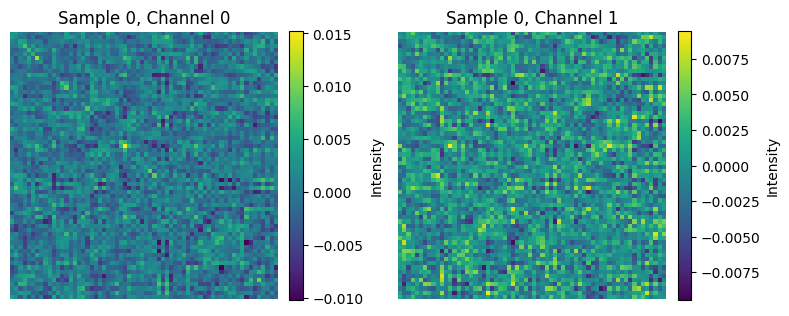

In [16]:
noise_data = loaderTr1 - loaderLabel1

def plot_data(x, sample=0):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    im0 = axes[0].imshow(x[sample, :, :, 0], cmap='viridis')
    axes[0].set_title(f"Sample {sample}, Channel 0")
    axes[0].axis("off")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Intensity")

    im1 = axes[1].imshow(x[sample, :, :, 1], cmap='viridis')
    axes[1].set_title(f"Sample {sample}, Channel 1")
    axes[1].axis("off")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="Intensity")

    plt.tight_layout()
    plt.show()

plot_data(noise_data, sample=0)

C:\Users\yushe\AppData\Local\Temp\ipykernel_14928\3529116412.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


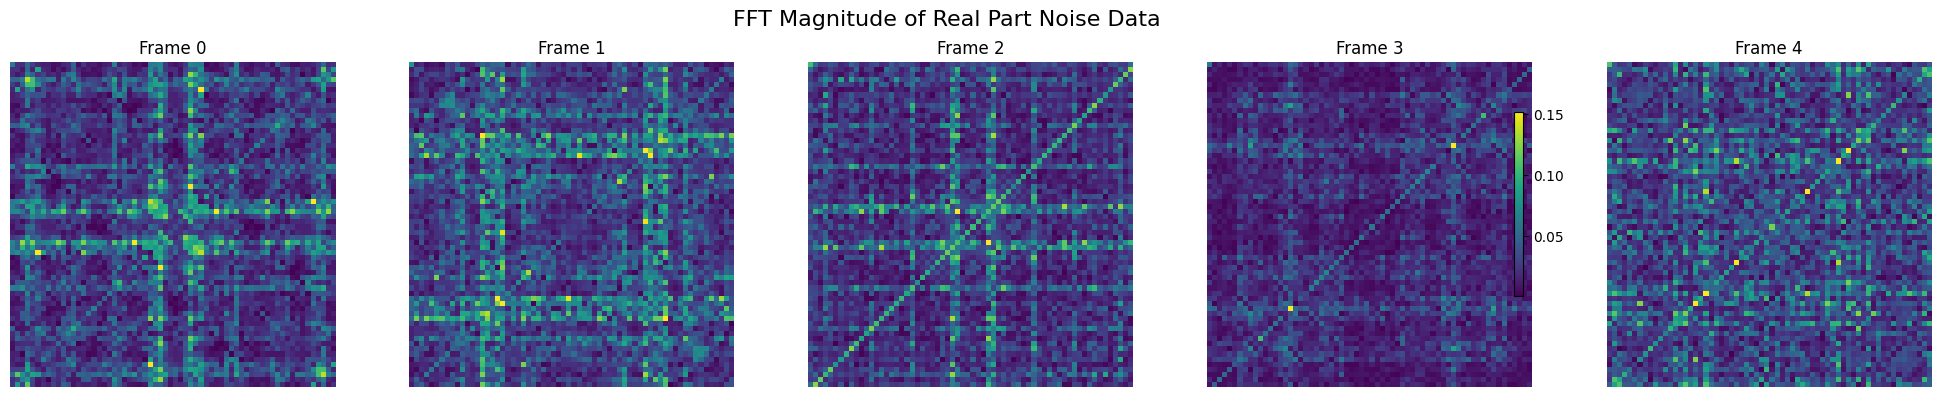

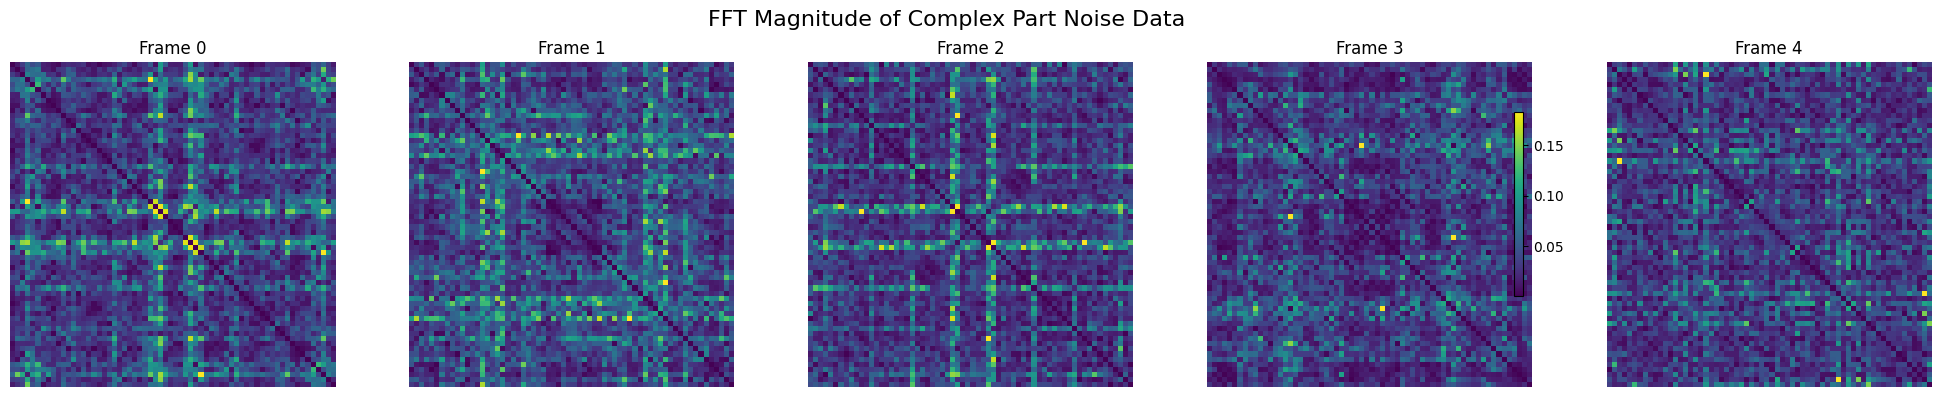

In [15]:
from numpy.fft import fft2, fftshift

def plot_fft(noise_data, custom_title="FFT Magnitude of Noise Data"):
    fft_results = np.fft.fft2(noise_data, axes=(1, 2))
    fft_magnitude = np.abs(np.fft.fftshift(fft_results, axes=(1, 2)))
    log_magnitude = np.log1p(fft_magnitude)
    N = min(5, noise_data.shape[0])

    fig, axes = plt.subplots(1, N, figsize=(4 * N, 4))

    for i in range(N):
        ax = axes[i] if N > 1 else axes  # handle case when N = 1
        im = ax.imshow(log_magnitude[i], cmap='viridis')
        ax.set_title(f"Frame {i}")
        ax.axis('off')

    fig.suptitle(custom_title, fontsize=16)
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_fft(noise_data[:, :, :, 0], custom_title="FFT Magnitude of Real Part Noise Data")
plot_fft(noise_data[:, :, :, 1], custom_title="FFT Magnitude of Complex Part Noise Data")

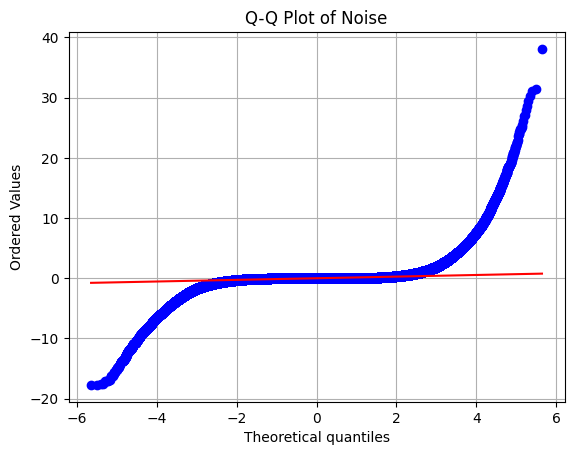

In [18]:
import scipy.stats as stats

stats.probplot(noise_data[:, :, :, 0].flatten(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Noise")
plt.grid(True)
plt.show()

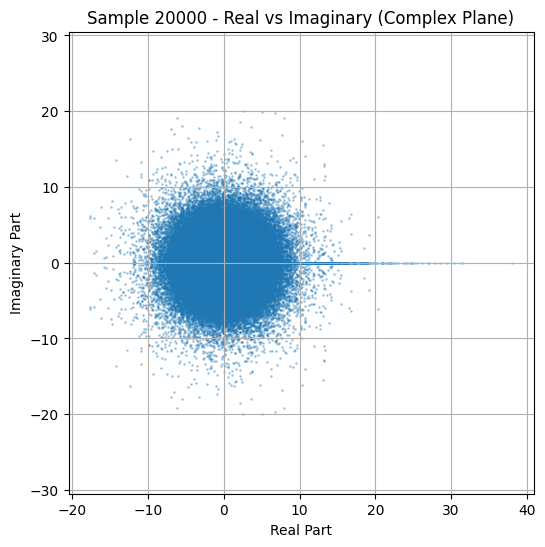

Real Part Mean: 0.0024, Std: 0.2373
Imaginary Part Mean: -0.0000, Std: 0.2255


In [25]:
def plot_scatter_noise(noise_data, sample=0):
    real = noise_data[:, :, :, 0].flatten()
    imag = noise_data[:, :, :, 1].flatten()

    plt.figure(figsize=(6, 6))
    plt.scatter(real, imag, alpha=0.3, s=1)
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.title(f"Sample {sample} - Real vs Imaginary (Complex Plane)")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

    print(f"Real Part Mean: {np.mean(real):.4f}, Std: {np.std(real):.4f}")
    print(f"Imaginary Part Mean: {np.mean(imag):.4f}, Std: {np.std(imag):.4f}")

plot_scatter_noise(noise_data, sample=20000)

The noise are Complex Correlated Gaussian Distributed.

In [3]:
import torch
from SVDNN import SVDNet  # Adjust if your model is in another file

def shrink_model(original_model_path: str, output_path: str):
    M, N, r = 64, 64, 32
    model = SVDNet(M=M, N=N, r=r)

    # Load state dict (not full model)
    state_dict = torch.load(original_model_path, map_location='cpu')
    model.load_state_dict(state_dict)

    # Save compact version (state_dict only, on CPU)
    torch.save(model.state_dict(), output_path)
    print(f"✅ Saved compact model to: {output_path}")


shrink_model("SVDNet_model.pth", "svdnet.pth")

C:\Users\yushe\AppData\Local\Temp\ipykernel_28644\2510230026.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(original_model_path, map_location='c

✅ Saved compact model to: svdnet.pth


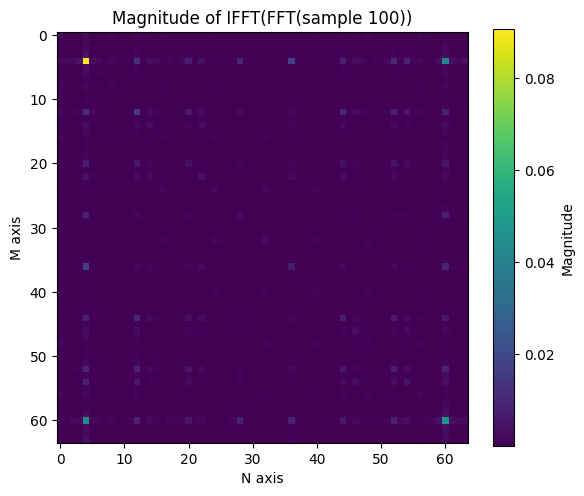

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
aa = np.load('CompetitionData1/Round1TrainLabel1.npy')  # Shape: (B, M, N, 2)

# Select the 100th sample (index 100)
aa_1 = aa[100]  # Shape: (M, N, 2)

# Convert to complex matrix
aa_1_complex = aa_1[..., 0] + 1j * aa_1[..., 1]  # Shape: (M, N), dtype=complex64/complex128

# Apply FFT and then IFFT
aa_1_fft = np.fft.ifft(np.fft.fft(aa_1_complex, axis=0), axis=1)  # Shape: (M, N), complex

# Plot the absolute value
plt.figure(figsize=(6, 5))
plt.imshow(np.abs(aa_1_fft), cmap='viridis')
plt.title("Magnitude of IFFT(FFT(sample 100))")
plt.colorbar(label="Magnitude")
plt.xlabel("N axis")
plt.ylabel("M axis")
plt.tight_layout()
plt.show()